In [1]:
# imports

import keras
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import uproot
import awkward as ak

import pandas as pd
import seaborn as sns

2022-10-10 13:47:38.019378: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# latex settings block

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.numpoints": 1,
    "axes.linewidth": 2,
    "legend.title_fontsize": 18,
    "axes.labelsize": 18,
    "legend.fontsize": 16
})

In [34]:
# take the feature labels out of a root file
with uproot.open(f"root_files/ntuple_merged_10.root:deepntuplizer/tree;42") as tree:
    features = ['label_H_bb','fj_jetNTracks','fj_nSV']+[x for x in tree.keys() if x[:6]=='fj_tau' or x[:8]=='fj_track'] 

# 2 labels: QCD or Hbb. Logical "and" of labels is used.
labels = ['sample_isQCD',
          'label_H_bb']

nfeatures = len(features)
nlabels = len(labels)

In [35]:
def get_features(file_name):
    '''
    Function that extracts our chosen feature and label arrays from a root file
    for the events that are labeled as QCD or Hbb and returns two 2D arrays.
    The first array is the features array and has the shape (nummber_of_events, number_of_features).
    The second array is the labels array ans has the shape (number_of_events, 2)
    '''
    with uproot.open(f"{file_name}:deepntuplizer/tree;42") as tree:

        feature_array = np.stack(list(tree.arrays(features,library='np').values()),axis=-1)
        label_array = np.stack(tree.arrays(labels,library='np'),axis=-1)
        #label_array = np.stack([get_labels(tree,i) for i in labels],axis=-1)
        
#         feature_array = feature_array[label_array==1]
#         label_array = label_array[label_array==1]
        
    return feature_array, label_array

In [36]:
# load features and labels arrays for a training file

feature_array, label_array = get_features('root_files/ntuple_merged_10.root')

### Attempting to a Correlation Plot

In [37]:
data = pd.DataFrame(data=feature_array, columns = features)

In [38]:
data.head()

,label_H_bb,fj_jetNTracks,fj_nSV,fj_tau0_trackEtaRel_0,fj_tau0_trackEtaRel_1,fj_tau0_trackEtaRel_2,fj_tau1,fj_tau1_trackEtaRel_0,fj_tau1_trackEtaRel_1,fj_tau1_trackEtaRel_2,...,fj_trackSip2dSigAboveBottom_1,fj_trackSip2dSigAboveCharm_0,fj_trackSipdSig_0,fj_trackSipdSig_0_0,fj_trackSipdSig_0_1,fj_trackSipdSig_1,fj_trackSipdSig_1_0,fj_trackSipdSig_1_1,fj_trackSipdSig_2,fj_trackSipdSig_3
0,0.0,11.0,4.0,2.996319,3.003719,4.022275,0.370185,2.888846,3.370836,3.45442,...,2.508579,3.643171,43.235855,2.527875,-1.618132,30.447222,43.235855,30.447222,2.527875,-0.550020
1,0.0,12.0,1.0,4.115133,5.333707,7.419932,0.021066,-1.000000,-1.000000,-1.00000,...,1.423004,2.222215,1.751387,-1.735610,-24.784317,1.676282,1.751387,1.676282,1.298006,0.640133
2,0.0,11.0,0.0,-1.000000,-1.000000,-1.000000,0.126134,-1.000000,-1.000000,-1.00000,...,0.711080,1.830022,9.411595,0.838284,-50.000000,2.482426,9.411595,2.482426,2.204618,2.118999
3,1.0,10.0,0.0,-1.000000,-1.000000,-1.000000,0.052131,-1.000000,-1.000000,-1.00000,...,1.940743,5.326025,18.116814,1.159444,0.492347,3.425295,18.116814,3.425295,1.159444,0.549124
4,0.0,6.0,0.0,-1.000000,-1.000000,-1.000000,0.016376,-1.000000,-1.000000,-1.00000,...,1.426428,1.935620,1.447032,1.447032,0.793008,0.793008,-1.907130,-3.385496,-0.646736,-1.414297


In [39]:
corr = data.corr()

/var/folders/n1/q0yl5j2d5qvcnc78yw8rs7qw0000gn/T/ipykernel_15979/3185258878.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


<AxesSubplot: >

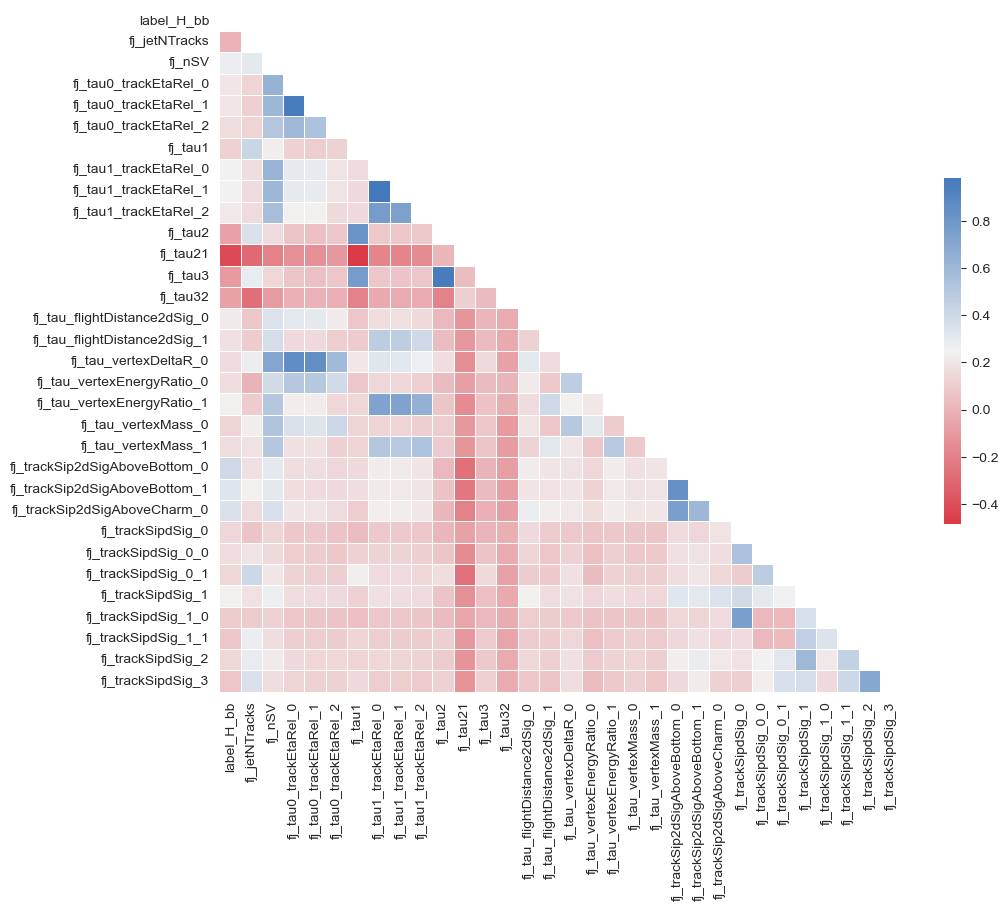

In [40]:
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.set_style(style = 'white')
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, 
        square=True,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [7]:
# build a simple neural network in keras

keras_model = keras.Sequential()
keras_model.add(Dense(units=32,activation='relu',input_dim=nfeatures))
keras_model.add(Dense(units=32,activation='relu'))
keras_model.add(Dense(units=nlabels,activation='softmax'))
keras_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(keras_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1024      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 2,146
Trainable params: 2,146
Non-trainable params: 0
_________________________________________________________________
None


2022-10-05 20:21:48.512543: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# change to sgd
# check learning rate
# figure loss after 10 epochs vs learning rate

In [9]:
# fit keras model
keras_model.fit(feature_array, label_array, batch_size=1024, 
                epochs=100, validation_split=0.2)

Epoch 1/100
147/147 [==============================] - 1s 3ms/step - loss: 0.3891 - accuracy: 0.8825 - val_loss: 0.2728 - val_accuracy: 0.8995
Epoch 2/100
147/147 [==============================] - 0s 3ms/step - loss: 0.2619 - accuracy: 0.9004 - val_loss: 0.2531 - val_accuracy: 0.9043
Epoch 3/100
147/147 [==============================] - 0s 3ms/step - loss: 0.2483 - accuracy: 0.9029 - val_loss: 0.2456 - val_accuracy: 0.9057
Epoch 4/100
147/147 [==============================] - 0s 2ms/step - loss: 0.2386 - accuracy: 0.9064 - val_loss: 0.2395 - val_accuracy: 0.9059
Epoch 5/100
147/147 [==============================] - 0s 2ms/step - loss: 0.2310 - accuracy: 0.9089 - val_loss: 0.2296 - val_accuracy: 0.9107
Epoch 6/100
147/147 [==============================] - 0s 2ms/step - loss: 0.2232 - accuracy: 0.9113 - val_loss: 0.2228 - val_accuracy: 0.9116
Epoch 7/100
147/147 [==============================] - 0s 2ms/step - loss: 0.2173 - accuracy: 0.9137 - val_loss: 0.2180 - val_accuracy: 0.9130

Epoch 58/100
147/147 [==============================] - 0s 2ms/step - loss: 0.1660 - accuracy: 0.9346 - val_loss: 0.1707 - val_accuracy: 0.9338
Epoch 59/100
147/147 [==============================] - 0s 2ms/step - loss: 0.1643 - accuracy: 0.9351 - val_loss: 0.1712 - val_accuracy: 0.9332
Epoch 60/100
147/147 [==============================] - 0s 2ms/step - loss: 0.1649 - accuracy: 0.9346 - val_loss: 0.1726 - val_accuracy: 0.9330
Epoch 61/100
147/147 [==============================] - 0s 2ms/step - loss: 0.1642 - accuracy: 0.9348 - val_loss: 0.1723 - val_accuracy: 0.9330
Epoch 62/100
147/147 [==============================] - 0s 3ms/step - loss: 0.1637 - accuracy: 0.9356 - val_loss: 0.1702 - val_accuracy: 0.9328
Epoch 63/100
147/147 [==============================] - 0s 3ms/step - loss: 0.1652 - accuracy: 0.9346 - val_loss: 0.1722 - val_accuracy: 0.9327
Epoch 64/100
147/147 [==============================] - 0s 3ms/step - loss: 0.1633 - accuracy: 0.9352 - val_loss: 0.1699 - val_accuracy:

In [10]:
# load features and labels arrays for a testing file
feature_array_test, label_array_test = get_features('root_files/ntuple_merged_0.root')

In [12]:
# run model inference on test data set
predict_array_test = keras_model.predict(feature_array_test)

# create ROC curve
fpr, tpr, threshold = roc_curve(label_array_test[:,1], predict_array_test[:,1])
    


5873/5873 [==============================] - 4s 740us/step


In [17]:
# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label="curve")   #f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('ROC.pdf')
plt.show()

RuntimeError: Failed to process string with tex because latex could not be found

Error in callback <function _draw_all_if_interactive at 0x18a0760e0> (for post_execute):


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 1 Axes>

In [23]:
#plt.figure()
plt.plot(fpr, tpr) #, lw=2, label="curve")

Error in callback <function _draw_all_if_interactive at 0x18a0760e0> (for post_execute):


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 1 Axes>